<a href="https://colab.research.google.com/github/desmond-rn/inverse-problem-vnet/blob/master/notebooks/ApprentissageVnet%20-%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplifcation d'un VNET pour la reconstruction de la densité d'un domaine

L'objectif de ce notebook est de **reconstruire la dénsité d'un domaine** à l'aide des signaux récupérés sur ses bords. Il s'agit d'un problème inverse qu'on va résoudre à l'aide d'un Vnet. 

In [2]:
%reset -f

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import sklearn
from sklearn import metrics
import struct
from keras import backend as K


import gc
from IPython.display import Image
from ast import literal_eval as l_eval

In [4]:
np.set_printoptions(precision = 3)

## Les données

In [5]:
""" DEPUIS GOOGLE DRIVE """
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/InverseProblem/data
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/InverseProblem/data

 df_simu.csv   train/      VNET01.h5             VNET04_best.h5
 img/          val/       'VNET03[12ch].h5'      VNET05.h5
 test/         VNET00.h5  'VNET04[24Ch-00].h5'   VNET06.h5


### Desciption des sorties

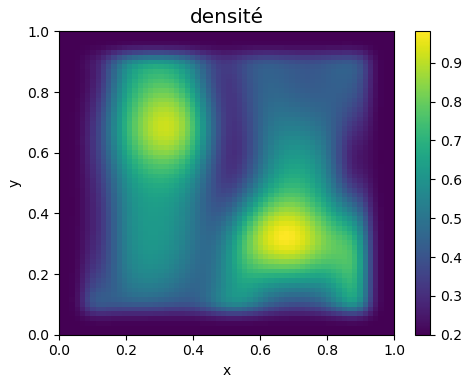

In [7]:
## On veut prédire la densité
Image("../notebooks/img/DensiteTest.png",width="500")

### Desciption des entrées

**Contrairement à l'entrainement précédent**, nous ne conservons que le signal à la source et celui à l'opposé de cette source (bien évidemment les trois cannaux $E$, $F$, et $T$ dudit signal). Ce qui nous donne au total $4 \times 2 \times 3 = 24$ cannaux pour les antrées. La figure ci-bas illutre la simplification apportée !

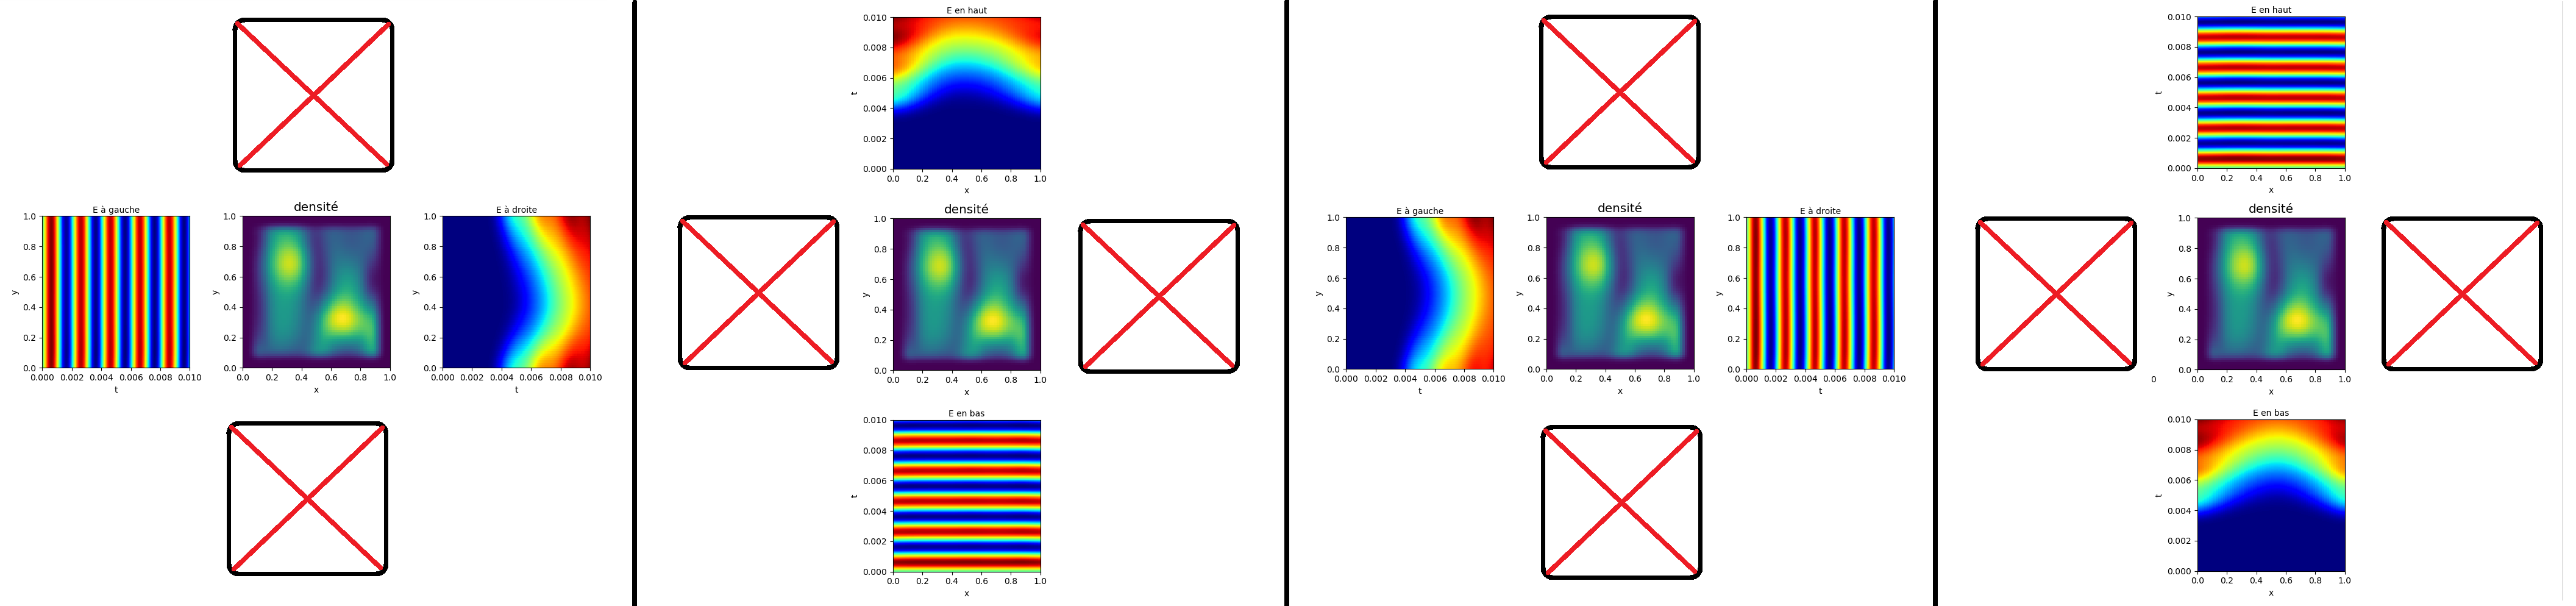

In [10]:
## Input for the Vnet
Image("../notebooks/img/SimuCirculaires - 24.png",width="1600")

### Recupération des données

Les données ont été prétraitées (reéchantillonées, normalisées, shufflelisées, etc.) dans un notebook précédent.

In [8]:
X_train = np.load("train/newX.npy")
Y_train = np.load("train/Y.npy")
print("Train shapes", X_train.shape, Y_train.shape)
print()
print("X Max and Min: ", X_train.max(), X_train.min())
print("Y Max and Min: ", Y_train.max(), Y_train.min())

Train shapes (1950, 64, 64, 24) (1950, 64, 64, 1)

X Max and Min:  1.0 0.0
Y Max and Min:  1.0 0.10091702238501658


In [9]:

X_val = np.load("val/newX.npy")
Y_val = np.load("val/Y.npy")
print("Validation shapes", X_val.shape, Y_val.shape)

Validation shapes (750, 64, 64, 24) (750, 64, 64, 1)


In [10]:
X_test = np.load("test/newX.npy")
Y_test = np.load("test/Y.npy")[:,:,:,0]   ## derniere dimension inutile pour les plots
print("Test shapes", X_test.shape, Y_test.shape)

Test shapes (183, 64, 64, 24) (183, 64, 64)


## Description et construction du Vnet

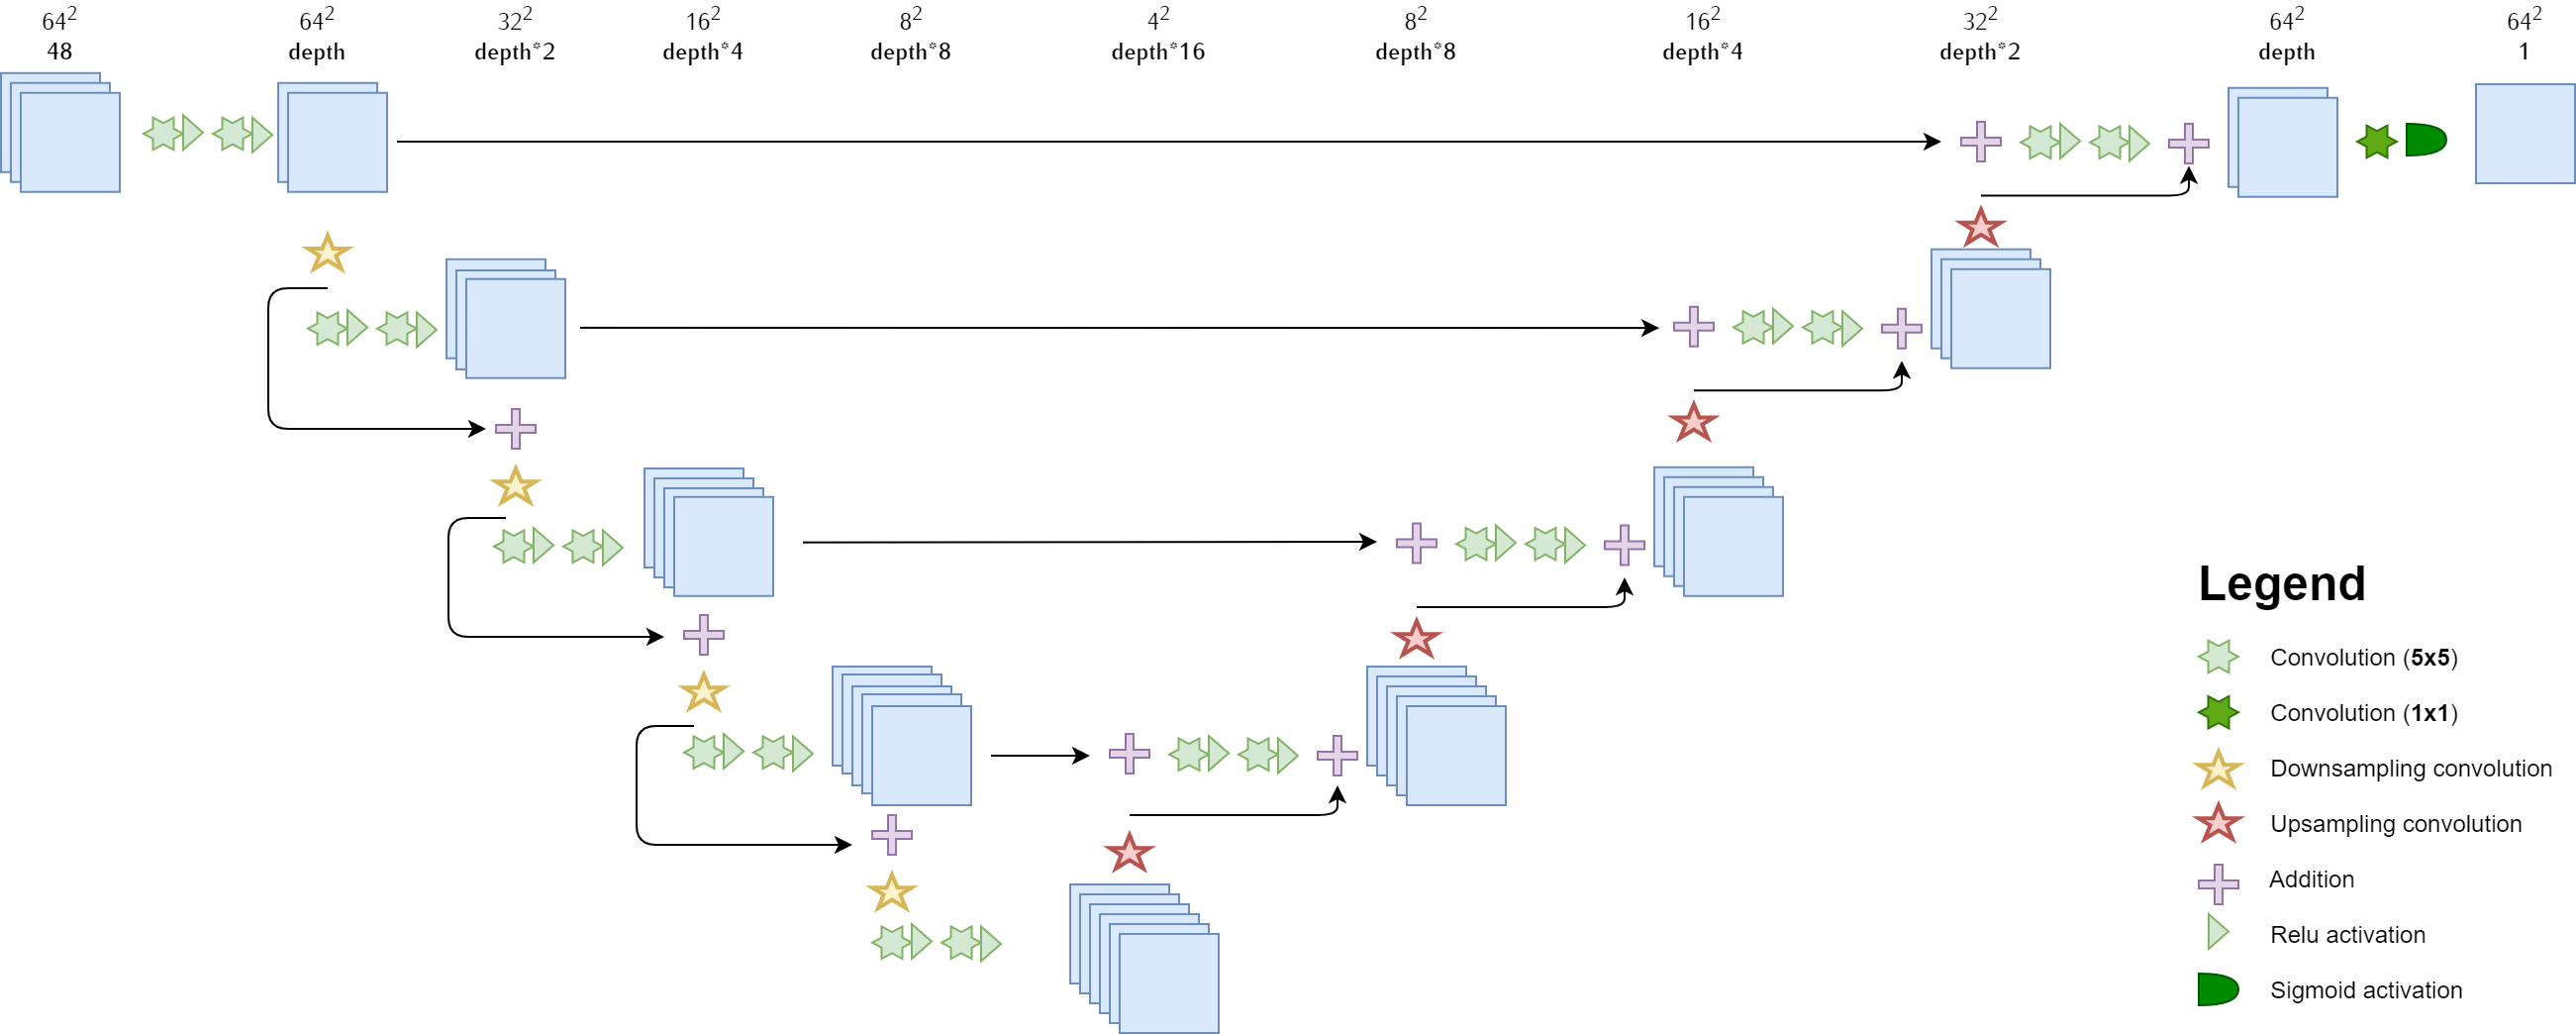

In [11]:
Image("../notebooks/img/Vnet.png",width="800")

Le code est presque identique à celui du précédent notebook. La majeure différence est au niveau de l'utilisation de **noyaux constants** pour les convolutions transposées. 

In [12]:
Conv = tf.keras.layers.Conv2D                           ## Convolution
DeConv = tf.keras.layers.Conv2DTranspose                ## Deconvolution
SpatialDropout = tf.keras.layers.SpatialDropout2D       ## Dropout

class VNet:
    
    def __init__(self,
                 input_shape,
                 output_shape,                  
                 levels=5,                      ## Le nombre de niveaux 
                 depth=32,                       ## Le nombre de channel au niveau 1
                 kernel_size=5, 
                 activation="relu",
                 batch_norm=True,
                 dropout_rate=0, 
                 ): 

        self.input_shape=input_shape
        self.output_shape=output_shape
        self.levels = levels
        self.depth = depth
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm=batch_norm
        self.dropout_rate = dropout_rate

        assert len(input_shape)==3
        assert len(output_shape)==3
        assert (input_shape[0], input_shape[1]) == (output_shape[0], output_shape[1]), "Input and output dimensions should be alike in a VNET"

        ##---------- Le model, ses inputs et des outputs -----------##
        inputs= tf.keras.Input(shape=input_shape)
        logits= self.body(inputs)

        if self.output_shape[2]==1:    ## Output number of channels equals 1
            outputs = Conv(1,1, activation='sigmoid')(logits)                         ## On utilise une sigmoid parceque les donnees ont éte normalisées
        else:   
            outputs = Conv(self.input_shape[2],1, activation='softmax')(logits)       ## Le softmax peut servir a avoir une image RGB par exemple, c'est pas specifiquement lié à la classification

        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        ##----------------------------------------------------------##
        
    def doubleConv(self, Y, depth):
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)    ## On pourra essayer avec valid comme dans le papier!
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)
        if self.batch_norm:
            Y = tf.keras.layers.BatchNormalization()(Y)
        if self.dropout_rate>0:                             ## S'il n'ya pas de dropout, on ne fait rien !
            Y = SpatialDropout(self.dropout_rate)(Y)        ## Dans le SpatialDropout, si on cache une portion de l'image, on la cahe totalement. Pas la peine de chacher seulement certains neurones! 
        return Y

    def makeDown(self, Y, depth):       ## Une simple descente d'un level au suivant
        down = Conv(depth, 2, strides=2, padding="same")(Y)
        return down

    def makeUp(self, Y, depth):         ## une simple remontée 
        # up = DeConv(depth, 2, strides=2, padding="same")(Y)
        up = DeConv(depth, 2, strides=2, padding="same", kernel_initializer=keras.initializers.Constant(value=1/(2*2*depth)))(Y)
        return up

    def body(self,inputs):
        left = {}     ## On sauvegarde la partie gauche à additionner avec la partie droite
        left[0] = self.doubleConv(inputs,self.depth)
        print("left[0].shape =",left[0].shape)
        for i in range(1, self.levels):                           ## Une boucle pour la descente
            down = self.makeDown(left[i-1], self.depth*2**i)
            conv = self.doubleConv(down, self.depth*2**i)
            left[i] = tf.keras.layers.Add()([down, conv])         ## L'addition c'est comme des racourcis à la resnet ## essayons des multiplications
            if i<self.levels-1:
                print(f"left[{i}].shape=",left[i].shape)

        central = left[self.levels-1]
        print(f"central.shape=",central.shape)

        right=central
        for i in range(self.levels-2, -1,-1):                     ## une boucle pour la remontée
            up = self.makeUp(right, self.depth*2**i)
            add = tf.keras.layers.Add()([left[i], up])
            conv = self.doubleConv(add, self.depth*2**i)
            right = tf.keras.layers.Add()([up, conv])
            print(f"right[{i}].shape =",right.shape)

        return right

    @tf.function                                              ## Pour accelerer le code lors des prédictions
    def __call__(self,inputs):
        return self.model(inputs)

In [13]:
modelParams= {'input_shape':(64,64,24),
              'output_shape':(64,64,1),
              'levels':5,
              'depth':10,
              'kernel_size':5,
              'activation':'relu',
              'batch_norm': True,
              'dropout_rate': 0.0}

tf.config.run_functions_eagerly(False)   ## True pour une desactivation de tf.function

## Petit résumé du modèle
myVnet = VNet(**modelParams)

left[0].shape = (None, 64, 64, 10)
left[1].shape= (None, 32, 32, 20)
left[2].shape= (None, 16, 16, 40)
left[3].shape= (None, 8, 8, 80)
central.shape= (None, 4, 4, 160)
right[3].shape = (None, 8, 8, 80)
right[2].shape = (None, 16, 16, 40)
right[1].shape = (None, 32, 32, 20)
right[0].shape = (None, 64, 64, 10)


In [14]:
## Gros résumé du modèle
# myVnet.model.summary()

Une autre différence majeures entre ce Vnet et le précédent est que la $depth = 10$ alors qu'avant, $depth=32$. Tout ceci simplifie considérablement le réseau. En tenant compte de la réduction du nombre de cannaux en entrées, on obtient un apprentissage bien **plus rapide** (computationellement moins coûteux). Comme on va le voire par la suite, on obtient des meilleures résultats.

## Les fonctions pour l'entraînement 

### Le score $R^2$


In [16]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=None) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=None)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

In [17]:
## Chargement des poids et continuation de l'apprentissage
# myVnet.model = keras.models.load_model("VNET06.h5", custom_objects={"r2_score": r2_score}, compile=False)

myVnet.model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="MSE", metrics=[r2_score])

### Les fonctions de Callback

In [ ]:
""" Pour une decroissance du taux d'apprentissage """
def scheduler(epoch, lr):
    if epoch < 900:
      ret = 1e-5
    elif epoch < 1100:
      ret = 5e-6
    else:
      ret = 1e-6
    return ret

    # return lr*(0.996**epoch)

lr_decrease = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
""" Learning rate decay """
early_stopping = keras.callbacks.EarlyStopping(patience=20, monitor="r2_score", mode="max", restore_best_weights=True)    ## Bug with monitor argument !

## L'entraînement proprement dit 

On définit des variables à visualiser.

In [ ]:
loss = []
val_loss = []

r2_score = []
val_r2_score = []

In [ ]:
nb_epochs=0     ## Ne pas reinitialiser cette variables. Elle indique le nombre total d'époques effectuées.

In [ ]:
## Relancer cette cellule autant de fois

for i in range(1200):   ## Nonbre d'époques à efectuer, l'une après l'autre 

    print("epoch nb:", nb_epochs)    ## Le nombre d'époques effectuées jusqu'a présent

    #####--------------- Chargement directe des données en mémoire ---------######
    history = myVnet.model.fit(
              x=X_train,
              y=Y_train,
              batch_size=100,
              initial_epoch=nb_epochs,            ## Tant que la variable nb_epochs n'est pas reinitialisée, on continue l'entrainement
              epochs=nb_epochs+1,                 ## On effectue une époque à la fois 
              validation_data=(X_val,Y_val),
              callbacks=[lr_decrease, early_stopping],
              verbose=2
              )
    #####-------------------------------------------------------------------######

    loss.append(history.history["loss"][0])
    val_loss.append(history.history["val_loss"][0])
    r2_score.append(history.history["r2_score"][0])
    val_r2_score.append(history.history["val_r2_score"][0])

    nb_epochs += 1

    gc.collect()    ## Collect all unused memory for another group of epochs

epoch nb: 0
20/20 - 40s - loss: 0.1154 - r2_score: -2.8481e+00 - val_loss: 0.0632 - val_r2_score: -2.0930e+00 - lr: 1.0000e-05 - 40s/epoch - 2s/step
epoch nb: 1
Epoch 2/2
20/20 - 6s - loss: 0.1016 - r2_score: -2.3799e+00 - val_loss: 0.0772 - val_r2_score: -2.8191e+00 - lr: 1.0000e-05 - 6s/epoch - 278ms/step
epoch nb: 2
Epoch 3/3
20/20 - 6s - loss: 0.0922 - r2_score: -2.0721e+00 - val_loss: 0.0904 - val_r2_score: -3.4882e+00 - lr: 1.0000e-05 - 6s/epoch - 281ms/step
epoch nb: 3
Epoch 4/4
20/20 - 6s - loss: 0.0858 - r2_score: -1.8845e+00 - val_loss: 0.1029 - val_r2_score: -4.1167e+00 - lr: 1.0000e-05 - 6s/epoch - 276ms/step
epoch nb: 4
Epoch 5/5
20/20 - 6s - loss: 0.0804 - r2_score: -1.6826e+00 - val_loss: 0.1141 - val_r2_score: -4.6747e+00 - lr: 1.0000e-05 - 6s/epoch - 278ms/step
epoch nb: 5
Epoch 6/6
20/20 - 6s - loss: 0.0752 - r2_score: -1.5441e+00 - val_loss: 0.1254 - val_r2_score: -5.2365e+00 - lr: 1.0000e-05 - 6s/epoch - 276ms/step
epoch nb: 6
Epoch 7/7
20/20 - 6s - loss: 0.0691 - r

Après 1200 époques, on atteint un score $R^2$ de **89%**. En terme de score, ce n'est pas forcément meilleure que le notebook précédent, mais globalement, c'est bien meilleure.

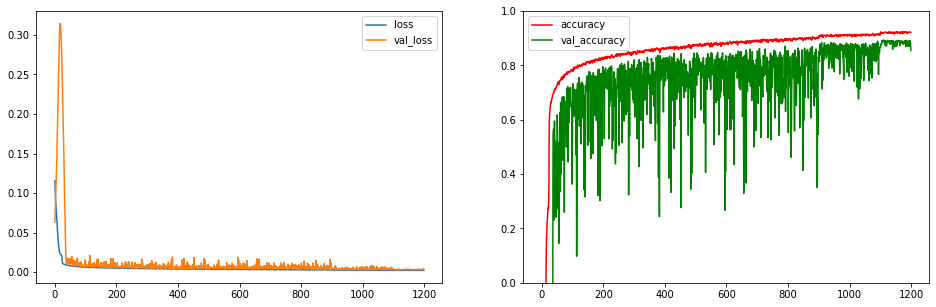

In [ ]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))

ax1.plot(np.array(loss),label="loss")
ax1.plot(np.array(val_loss),label="val_loss")
ax1.legend();

ax2.plot(np.array(r2_score),label="accuracy", c="r")
ax2.plot(np.array(val_r2_score),label="val_accuracy", c="g")
ax2.set_ylim(0,1)
ax2.legend();

Dans ce notebook, les taux d'apprentissage décroissants ($lr$ decay) sont:


*   Pour $0 \leq \text{epoch} < 900$, on a $lr=1e^{-5}$
*   Pour $900 \leq \text{epoch} < 1100$, on a $lr=5e^{-6}$
*   Pour $1100 \leq \text{epoch} < 1200$, on a $lr=1e^{-6}$

Alors que dans le notebook précédent:
*   Pour $0 \leq \text{epoch} < 500$, on avait $lr=1e^{-5}$
*   Pour $500 \leq \text{epoch} < 1000$, on avait $lr=1e^{-6}$
*   Pour $1000 \leq \text{epoch} < 1500$, on avait $lr=1e^{-7}$


## Quelques prédictions

In [18]:
hat_Y_test = myVnet.model.predict(X_test)[:,:,:,0]
# hat_Y_test.shape, hat_Y_test.max()

In [19]:
Y_test.shape, hat_Y_test.shape

((183, 64, 64), (183, 64, 64))

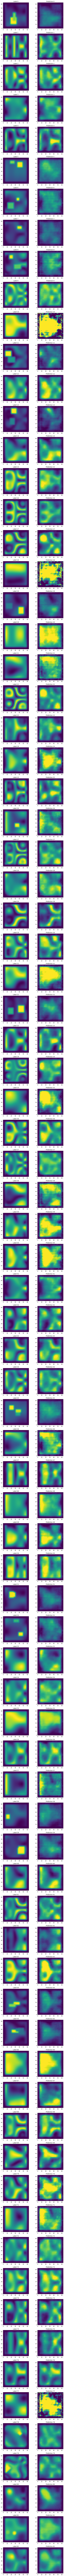

In [28]:
lenTest = int(len(Y_test)/2.2)

fig,ax=plt.subplots(lenTest,2, figsize=(2*5,lenTest*5))

# vmin, vmax = 0, 1
vmin, vmax = None, None

for i in range(lenTest):
    # vmin, vmax = min([Y_test[i].min(), hat_Y_test[i].min()]), max([Y_test[i].max(), hat_Y_test[i].max()])   ## Une échelle particulière a chaque paire (true, predict) 
    vmin, vmax = min([Y_test[i].min()]), max([Y_test[i].max()])
    # if i==0:
    ax[i,0].set_title("Label "+str(i))  
    ax[i,1].set_title("Prédiction "+str(i))  
    ax[i,0].imshow(Y_test[i], origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(hat_Y_test[i], origin="lower", vmin=vmin, vmax=vmax)

In [ ]:
""" La DICE 2D semble plus naturelle pour classer les prédictions """
def dice_coef(y_true, y_pred, smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred, axis=None)
    dice=(2. * intersection + smooth) / (tf.reduce_sum(y_true, axis=None) + tf.reduce_sum(y_pred,axis=None) + smooth)
    return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred):
    smooth=1e-5
    return 1.0 - dice_coef_multiD(y_true, y_pred, smooth)

[(55, 0.3086355016726111), (81, 0.3939949128802107), (66, 0.43706264559669306), (82, 0.4493206663011634), (78, 0.4740525400096486)]


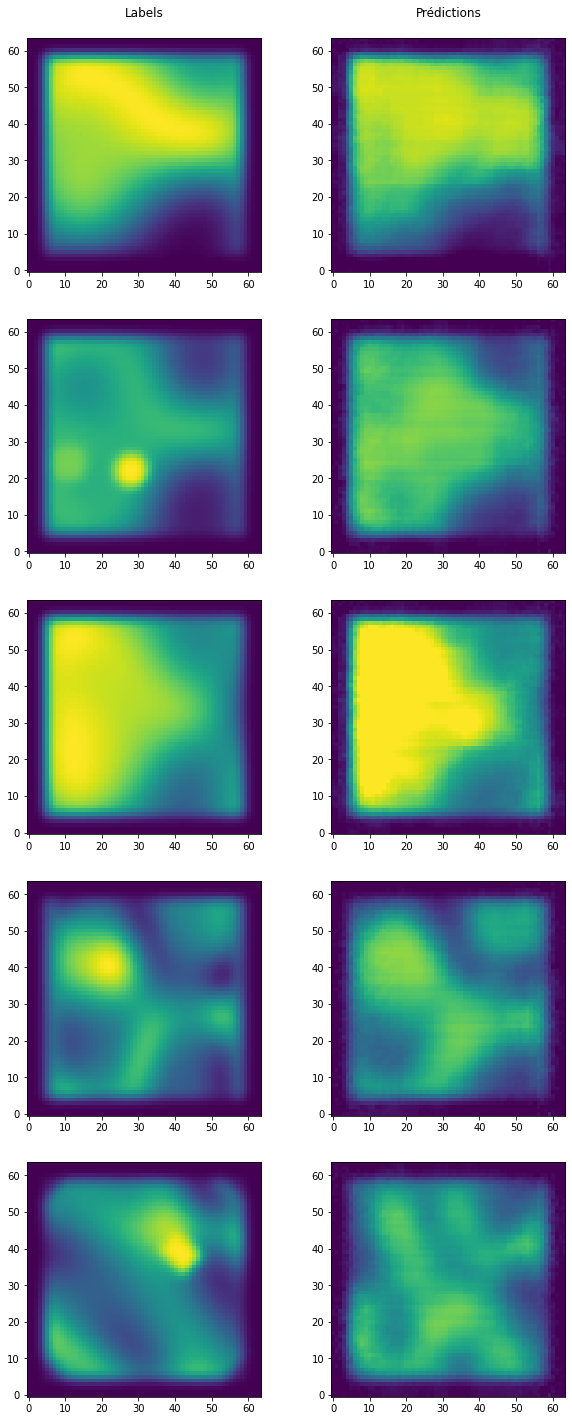

In [29]:
mse = tf.keras.losses.MeanSquaredError()
listErrors = []

for i in range(lenTest):
  ## On utilise la DICE cette fois (les meilleures prédictions sont plus naturelles ainsi)
  ## float64 pour éviter le bug Tensorflow 
  true = Y_test[i].astype('float64')
  pred = hat_Y_test[i].astype('float64')

  listErrors.append((i, dice_loss(true, pred).numpy()))

  # print(listErrors)

listErrors.sort(key=lambda x:x[1])
# print(listErrors[:5])

fig,ax=plt.subplots(5,2, figsize=(2*5,5*5))

for i in range(5):
    Y_true = Y_test[listErrors[i][0]]
    Y_pred = hat_Y_test[listErrors[i][0]]
    vmin, vmax = min([Y_true.min()]), max([Y_true.max()])
    
    if i==0:
      ax[i,0].set_title("Labels\n")  
      ax[i,1].set_title("Prédictions\n") 

    ax[i,0].imshow(Y_true, origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(Y_pred, origin="lower", vmin=vmin, vmax=vmax)

On constate que:   

*   Comme dans le notebook précédent, le Vnet a du mal avec les forme discontinues: cercle ⚫ et rectangle ⬛. 
*   Contrairement au notebook précédent, il n'ya plus d'artéfacts dans les prédictions



## Savegarde du model

In [30]:
# myVnet.model.save("VNET07.h5")